<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist.xlsx')
# df=pd.read_excel('unisim_hist.xlsx').iloc[:, :-5]
print(df.head())

        Date  Press      Np        Gp  Wp  Winj     Press_b    Np_b  \
0 2013-05-31    332       0         0   0     0  335.219147       0   
1 2013-06-30    332       0         0   0     0  335.219147       0   
2 2013-07-31    331   61938   6858068   0     0  333.438141   61938   
3 2013-08-31    329  124403  13532213   0     0  331.746216  124403   
4 2013-09-30    328  182423  20112443   0     0  330.207275  182423   

         Gp_b  Wp_b  Winj_b  
0         0.0     0       0  
1         0.0     0       0  
2   7027100.0     0       0  
3  14113900.0     0       0  
4  20696500.0     0       0  


In [241]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 0.000162
cw = 47.6E-06
Swi = 0.17 ** 0.35

In [242]:
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["dp"]= df["Press"].iloc[0]-df["Press"]
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,Winj_b,Rp,t,dt,dp,p_med,pmt
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,0.0,0.0,0,332.0,0.0
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,0,0.000000,30.0,30.0,0,332.0,0.0
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,0,110.724725,61.0,31.0,1,331.5,15.5
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,0,108.777224,92.0,31.0,3,330.0,77.5
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,0,110.251684,122.0,30.0,4,328.5,182.5


In [243]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [244]:
p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*df["dp"]

df.head()

,Date,Press,Np,Gp,Wp,Winj,Press_b,Np_b,Gp_b,Wp_b,...,p_med,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,335.219147,0,0.0,0,...,332.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,333.438141,61938,7027100.0,0,...,331.5,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329,124403,13532213,0,0,331.746216,124403,14113900.0,0,...,330.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328,182423,20112443,0,0,330.207275,182423,20696500.0,0,...,328.5,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943


In [245]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

In [246]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We
## We = (F-N*(Eo+mEg+(1+m)Efw)

## Schilthuis
## We = J∫(p_i-p).dt
## We = J.∑[p_i-p_j+1]*∆t
## We = J.pmt
## pmt = (F-N*(Eo+mEg+(1+m)Efw)/J

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m, pmt):
  # print(pmt)
  N = x[0]  # N é constante
  J = x[1]  # J é constante
  pmt_calc = (F - N * (Eo + m * Eg + (1 + m) * Efw)*10**6)/J
  # print(np.sum((pmt - pmt_calc) ** 2)/10**6)
  return np.sum((pmt - pmt_calc) ** 2)

# Chute inicial para N e J
x0 = np.array([100] + [1])  # 1 para N e 1 para J

# Limites para N e J
bounds = [(100, None)] + [(1, None)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m, pmt), bounds=bounds)

N_est = result.x[0]*10**6
J_est = result.x[1]
We_est = J_est*pmt

print(f"Estimativa de N: {N_est}")
print(f"Estimativas de J: {J_est}")
print(f"Estimativas de We: {We_est}")

Estimativa de N: 110705008.94296929
Estimativas de J: 11.496053993057426
Estimativas de We: [0.00000000e+00 0.00000000e+00 1.78188837e+02 8.90944184e+02
 2.09802985e+03 3.70172939e+03 5.77101910e+03 8.62204049e+03
 1.23640061e+04 1.65485697e+04 2.22506125e+04 2.88033633e+04
 3.64654833e+04 4.50875238e+04 5.54224763e+04 6.73611284e+04
 8.06390707e+04 9.61414995e+04 1.12006054e+05 1.28577616e+05
 1.45327367e+05 1.60456174e+05 1.77918680e+05 1.96369846e+05
 2.17039751e+05 2.38422412e+05 2.61943338e+05 2.86711587e+05
 3.11715504e+05 3.38622018e+05 3.65522785e+05 3.94032999e+05
 4.23255968e+05 4.51260355e+05 4.81730647e+05 5.11562907e+05
 5.42745953e+05 5.73267976e+05 6.05163778e+05 6.37415958e+05
 6.68800185e+05 7.01408742e+05 7.33137851e+05 7.66102786e+05
 7.99245910e+05 8.29181634e+05 8.62502947e+05 8.94921819e+05
 9.28421320e+05]


In [247]:
## Hurst Mod.
## We = C.∫[(pi-p)/ln(at)].dt
## We = C.∑[(pi-pj+1)/ln(at)]*∆t
## p_j+1_ = [p_j+p_j+1]/2
## ∆t = t_j+1-t_j
## j = 0....n-1

##Aquífero Hurst Modificado
# def we_pred2(t, C, a):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     pmt = (((p[0]-p_med[1:])*dt[1:])/np.log(a*t[1:])).cumsum()
#     pmt[pmt < 0] = 0
#     return np.append(np.zeros(1), C*pmt[0:len(t)])

# # Chute inicial para C e a
# initialGuess2=[15,0.01]

# # Ajuste da curva
# popt2,pcov2 = curve_fit(we_pred2, t, We_est, initialGuess2)

# fittedData2 = we_pred2(t, *popt2)
# r2_2 = r2_score(We_est, fittedData2)
# print(popt2, r2_2)

In [248]:
## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich
# def we_pred3(t, Wei, J):
#     dt=t-np.roll(t,1)
#     p_med=(p+np.roll(p,1))/2
#     we3=np.zeros(len(p))
#     pa_med=np.zeros(len(p))
#     for i in range(len(p)):
#         if p[i] >= p[0]:
#             dt[i] = 0
#             p_med[i] = p[0]
#             we3[i] = 0
#             pa_med[i] = p[0]
#         else:
#             dt[i]=t[i]-t[i-1]
#             p_med[i]=(p[i]+p[i-1])/2
#             we3[i]=we3[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
#             pa_med[i]=p[0]*(1-we3[i]/Wei)
#     return we3

# # Chute inicial para Wei e J
# initialGuess3=[1E6,1]

# # Ajuste da curva
# popt3,pcov3 = curve_fit(we_pred3, t, We_est, initialGuess3)

# fittedData3 = we_pred3(t, *popt3)
# r2_3 = r2_score(We_est, fittedData3)
# print(popt3, r2_3)

<ipython-input-249-39adda7d0aa8>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pimt[i]=pimt[i-1]+(p[0]-pmed)*(t[i]-t[i-1])


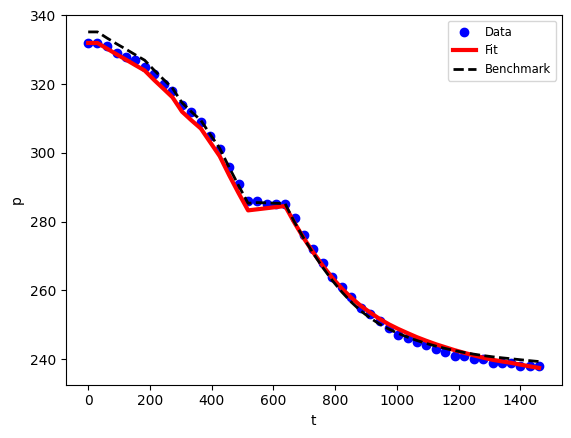

In [249]:
#Otimização

p_prev=np.zeros(len(t))
we_prev=np.zeros(len(t))
pimt=np.zeros(len(t))

def f_sch(pn, i):
    pmed=(p[i-1]+pn)/2
    pimt[i]=pimt[i-1]+(p[0]-pmed)*(t[i]-t[i-1])
    Sch=J_est*pimt[i]
    return Sch

def f_ebm(pn, i):
    Bo=bob+co*bob*(pb-pn)
    Bg=1.40676*pn**(-1.04229)
    F=npp[i]*(Bo+(rp[i]-Rsi)*Bg)+(wp[i]-winj[i])*Bw
    Eo=Bo-bo[0]
    Efw=bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
    EBM=F-N_est*(Eo+Efw)
    return EBM

for i in range(len(t)):
    if p[i] == p[0]:
        p_prev[i]=p[0]
        we_prev[i]=0
        pimt[i]=0
    else:
        pn=p[i-1]
        def f_obj(pn):
            Aquif=f_sch(pn, i)
            EBM=f_ebm(pn, i)
            return(EBM-Aquif)
        result=f_obj(pn)
        const = {'type':'eq', 'fun': f_obj}
        result=minimize(f_obj, pn, constraints=const)
        p_prev[i]=result.x[0]

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label="Fit", color="red", linewidth=3)
plt.plot(t, df["Press_b"], label="Benchmark", color="black", linewidth=2, linestyle='--')
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p")
plt.show()